# Задача

Тестовое задание для стажёра в команду Core ML

На датасете MovieLens 20M сравните два подхода к построению рекомендаций:

• коллаборативный: используйте только рейтинги. Например SVD-like алгоритмы, ALS, Implicit-ALS.

• коллаборативный + контентный: используйте рейтинги и всю дополнительную информацию о фильмах, имеющуюся в датасете. Например LightFM.

Для выполнения задания:

1    Выберите метрику и обоснуйте этот выбор.

**Для обучения я выбрал метрику precision@10. Precision@10 используется когда необходимо рекомендовать n лучших "вариантов". Ещё при анализе я использовал recall и coverage**

2    Придумайте и обоснуйте способ разбиения данных на обучение и валидацию.

**Столбцы входной таблицы отсортированы по временной метке. В качестве тренировочного набора взяты старые записи, а для тестового новые. Это имитирует работу рекомендационной модели**

3    Обратите внимание на сходимость обучения и настройку важных гиперпараметров моделей.

**В качестве средства настройки гиперпараметров я использовал библиотеку [optuna](https://optuna.org/)**

4    Выберите лучшую модель (При необходимости, оцените статистическую значимость результатов).

**Для всех выбранных метрик LightFM показал лучшие результаты чем SVD.**

5    Выложите на GitHub воспроизводимый код и краткий текстовый отчёт с выводами (можно в формате Jupyter Notebook).

**https://github.com/LiceyMaxim/VK_CoreML**


В поиске информации я нашёл статью, она послужила основой для решения. Поэтому я решил использовать холодный старт)
https://www.eigentheories.com/blog/lightfm-vs-hybridsvd/



### Я буду сравнивать SVD и LightFM.

# Установка неободимых библиотек

In [1]:
!pip install lightfm
!pip install optuna
!pip install tqdm
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git#egg=polara

  Cloning https://github.com/evfro/polara.git to /tmp/pip-install-vx0ra3ia/polara_b4396880452e4191a40207233e1457a7
  Running command git clone -q https://github.com/evfro/polara.git /tmp/pip-install-vx0ra3ia/polara_b4396880452e4191a40207233e1457a7


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna

from tqdm.auto import tqdm

from polara.recommender.coldstart.data import ItemColdStartData
from polara.recommender.coldstart.data import ItemColdStartSimilarityData
from polara.recommender.coldstart.models import LightFMItemColdStart
from polara.recommender.coldstart.models import ScaledSVDItemColdStart
from polara.evaluation.evaluation_engine import consolidate_metrics
from polara.lib.similarity import combine_similarity_data


P.S. optuna используется для подбора гиперпараметров в polara

In [3]:
seed = 42 # random seed
plt.style.use(["seaborn-notebook"])

# Загрузка данных и обработка

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1j4UDdE0qWxEOsHhMyBPi8hSCZSRyN9GA' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1j4UDdE0qWxEOsHhMyBPi8hSCZSRyN9GA" -O movies.csv && rm -rf /tmp/cookies.txt

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1JQWMelZa3ybAkI_mQibInwnr7HFCnWgM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1JQWMelZa3ybAkI_mQibInwnr7HFCnWgM" -O rating.csv && rm -rf /tmp/cookies.txt

Чтобы иметь использовать функции Polara для работы с данными, нам нужно дать им определенную структуру

In [4]:
movies = pd.read_csv("movie.csv")
ratings = pd.read_csv("rating.csv", skiprows=0, nrows=30000)
ratings = ratings.sort_values(by="timestamp")


Стандартный сплит 80/20. Разделение данных производится по метке времени. Обучение проводится на старых данных, а тестирование на новых. Этот способ разделения данных имитирует обучение на текущих данных для подготовки алгоритма к будущим данным.

In [5]:
train = ratings[: int(ratings.shape[0] * 0.8)]
test = ratings[int(ratings.shape[0] * 0.8) :]

train = train.drop("timestamp", 1)
test = test.drop("timestamp", 1)


/tmp/ipykernel_177015/2112087770.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train = train.drop("timestamp", 1)
/tmp/ipykernel_177015/2112087770.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test = test.drop("timestamp", 1)


In [6]:
movies = movies.drop("title", 1)
movies["genres"] = movies["genres"].str.split("|")

item_tags = movies

train = train.sample(frac=1, random_state=seed) 

item_tags = item_tags.set_index("movieId")


data_model = ItemColdStartData(
    train,
    *train.columns,
    item_features=item_tags,
    seed=seed
)

print(data_model)

data_model.test_ratio = 0.05  # 5% холода
data_model.prepare()


ItemColdStartData with Fields(userid='userId', itemid='movieId', feedback='rating')
Preparing data...
Done.
There are 22802 events in the training and 1198 events in the holdout.


/tmp/ipykernel_177015/1876061612.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  movies = movies.drop("title", 1)


In [7]:
num_threads = 4 # потоки
max_rank = 100
target_metric = "precision"

In [8]:
def create_lightfm_model(data_model, item_features, num_threads, seed=None):
    "Подготовка модель LightFM"
    model = LightFMItemColdStart(data_model, item_features=item_features)
    model.loss = "warp"
    model.learning_schedule = "adagrad"
    model.seed = seed
    model.fit_params["num_threads"] = num_threads
    return model


lfm = create_lightfm_model(data_model, item_tags, num_threads, seed)


In [9]:
def evaluate_lightfm(model):
    model._model.user_biases *= 0.0
    return model.evaluate()


def find_target_metric(metrics, target_metric):
    "Функция для быстрого извлечения необходимой метрики"
    for metric in metrics:
        if hasattr(metric, target_metric):
            return getattr(metric, target_metric)


def lightfm_objective(model, target_metric):
    "Фабрика функций для optuna"

    def objective(trial):
        model.rank = trial.suggest_int("rank", 1, max_rank)
        model.item_alpha = trial.suggest_loguniform("item_alpha", 1e-10, 1e-0)
        model.verbose = False
        model.build()
        metrics = evaluate_lightfm(model)
        target = find_target_metric(metrics, target_metric)
        trial.set_user_attr("epochs", model.fit_params["epochs"])
        trial.set_user_attr("metrics", metrics)
        return target

    return objective


n_trials = {
    15: 150,
    25: 100,
    50: 70,
    75: 50,
    100: 20,
    150: 10, 
}


# **SVD**

In [10]:
svd = ScaledSVDItemColdStart(data_model)

from polara.evaluation.pipelines import (
    find_optimal_config,
)

def fine_tune_scaledsvd(model, ranks, scale_params, target_metric):
    "Эффективная настройка ранга SVD для различных значений параметров масштабирования"
    rev_ranks = sorted(ranks, key=lambda x: -x)
    param_grid = [(s, r) for s in scale_params for r in rev_ranks]
    param_names = ("col_scaling", "rank")
    config, scores = find_optimal_config(
        model,
        param_grid,
        param_names,
        target_metric,
        return_scores=True,
        force_build=False,
        iterator=tqdm,
    )
    return config, scores


rank_grid = [1,] + list(range(5, max_rank + 1, 5))

scaling_grid = list(range(-8, 9, 2))
i = 0
for scale in scaling_grid:
    scaling_grid[i] = scale / 10
    i += 1
scaling_grid

svd_best_config, svd_scores = fine_tune_scaledsvd(
    svd, rank_grid, scaling_grid, target_metric
)


  0%|          | 0/189 [00:00<?, ?it/s]

# **LightFM**

In [11]:
objective = lightfm_objective(lfm, target_metric)

study = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed)
)

optuna.logging.disable_default_handler() 

for num_epochs, num_trials in tqdm(n_trials.items()):
    lfm.fit_params["epochs"] = num_epochs
    study.optimize(objective, n_trials=num_trials, n_jobs=1, catch=())


[I 2022-04-05 01:59:58,253] A new study created in memory with name: no-name-15463ea0-a354-455b-b6c7-c023a30bdbc3


  0%|          | 0/6 [00:00<?, ?it/s]

Trial 1 failed, because the objective function returned nan.
Trial 9 failed, because the objective function returned nan.
Trial 15 failed, because the objective function returned nan.
Trial 16 failed, because the objective function returned nan.
Trial 19 failed, because the objective function returned nan.
Trial 50 failed, because the objective function returned nan.
Trial 53 failed, because the objective function returned nan.
Trial 70 failed, because the objective function returned nan.
Trial 89 failed, because the objective function returned nan.
Trial 107 failed, because the objective function returned nan.
Trial 125 failed, because the objective function returned nan.
Trial 131 failed, because the objective function returned nan.
Trial 180 failed, because the objective function returned nan.
Trial 186 failed, because the objective function returned nan.
Trial 204 failed, because the objective function returned nan.
Trial 216 failed, because the objective function returned nan.
Tri

Для гиперпараметров я использовал Optuna. Потому что мне нравится этот фреймворк и есть такое видео https://www.youtube.com/watch?v=j7TcDsnup0o

In [12]:
print(
    f"Лучее значение {target_metric}={study.best_value:0.4f} было достигнуто с помощью"
    f'rank={study.best_params["rank"]} и item_alpha={study.best_params["item_alpha"]:.02e} '
    f'и количеством эпох={study.best_trial.user_attrs["epochs"]}.'
)


Лучее значение precision=2245971129879946432872448.0000 было достигнуто с помощьюrank=15 и item_alpha=3.11e-09 и количеством эпох=15.


# **Матрица подобия**


In [13]:
training_tags = item_tags.reindex(train["movieId"].unique(), fill_value=[])
tag_similarity = combine_similarity_data(training_tags, similarity_type="cosine")
print(
    "Матрица подобия "
    f"{tag_similarity.nnz / np.prod(tag_similarity.shape):.1%}."
)


Матрица подобия 46.3%.


In [14]:
similarities = {"users": None, "items": tag_similarity}
sim_indices = {"users": None, "items": training_tags.index}


In [15]:
data_model_sim = ItemColdStartSimilarityData(
    train,
    *train.columns,
    relations_matrices=similarities,
    relations_indices=sim_indices,
    item_features=item_tags,
    seed=seed
)
print(data_model_sim)


ItemColdStartSimilarityData with Fields(userid='userId', itemid='movieId', feedback='rating')


In [16]:
data_model_sim.test_ratio = data_model.test_ratio
data_model_sim.prepare()


Preparing data...
Done.
There are 22802 events in the training and 1198 events in the holdout.


# Оценка моделей

## Подготовка данных

Чтобы убрать разделения данных Polaris (а это обязательное действие для сравнения моделей), я буду использовать два метода `prepare_training_only` и `set_test`. Первый даст указание `data_model` использовать все обучающие данные для обучения без их разделения, а второй возьмёт тестовые данные, обеспечивая их общую согласованность. 

In [17]:
data_model_sim.prepare_training_only()
data_model_sim.set_test_data(holdout=test)


Preparing data...
Done.
There are 24000 events in the training and 0 events in the holdout.
47 unique userId entities within 5024 holdout interactions were filtered. Reason: not in the training data.
Done. There are 976 events in the holdout.


## Подготовка моделей для сравнения

Нам необходимо убедиться, что все модели используют одни и те же данные, чтобы избежать случайных расхождений в процедуре тестирования. После этого мы еще раз обучаем модели значениям гиперпараметров, найденным на этапе настройки, и выводим окончательные результаты.

### LightFM

In [18]:
lfm = create_lightfm_model(data_model_sim, item_tags, num_threads, seed)
lfm.rank = study.best_params["rank"]
lfm.item_alpha = study.best_params["item_alpha"]
lfm.fit_params["epochs"] = study.best_trial.user_attrs["epochs"]
lfm.build()


LightFM training time: 0.411s


### SVD

In [19]:
svd = ScaledSVDItemColdStart(data_model_sim)
svd.col_scaling = svd_best_config["col_scaling"]
svd.rank = svd_best_config["rank"]
svd.build()


PureSVD(cs)-s training time: 0.091s


## Анализ результатов

In [20]:
all_scores = {
    'SVD (лучшее)': svd.evaluate(),
    'LightFM (лучшее)': evaluate_lightfm(lfm)
}

In [21]:
all_scores_df = pd.concat(
    [consolidate_metrics(scores, model, False) for model, scores in all_scores.items()]
)


**На этапе настройки мы сосредоточились на метрике `precision@10`. Эта метрика используется, когда мы заинтересованы в том, чтобы рекомендовать пользователям товары из списка N лучших**

Теперь пришло время также ознакомиться с другими показателями, и в частности с показателем `coverage`. Показатель `coverage` характеризует тенденцию алгоритма генерировать одни и те же рекомендации снова и снова и, следовательно, связан с разнообразием рекомендаций.

In [22]:
(
    all_scores_df.dropna(axis=1)  # skip irrelevant metrics
    .loc[:, :"coverage"]
    .style.bar(subset=[target_metric, "coverage"])
)


,precision,recall,miss_rate,ndcg,map,arhr,coverage
SVD (лучшее),0.025231,0.231867,0.979938,0.125011,0.090959,0.096558,0.239583
LightFM (лучшее),0.278144,0.368731,0.993441,0.075819,0.067482,0.071922,0.427083


Как показано полосами в таблице выше, стандартная модель на основе SVD работает хуже как с точки зрения точности рекомендаций, так и с точки зрения разнообразия.

Text(0.5, 1.0, 'Combined evaluation results')

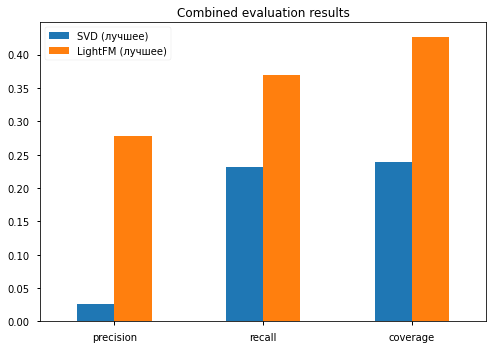

In [24]:
all_scores_df[["precision", "recall", "coverage"]].T.plot.bar(rot=0)
plt.title("Combined evaluation results")


Можно видеть, что алгоритм LightFM (Коллаборативный + контент) превосходит SVD (Коллаборативный) по каждому отдельному показателю, с которым мы экспериментировали.